In [19]:
import numpy as np
import matplotlib.pylab as plt
import random
import copy
import pandas
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.transforms import *

import pickle
from tqdm import *

Load Data
======

In [20]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [21]:
X = []
Y = []

for b in range(1, 6):
    D = unpickle('./cifar-10-batches-py/data_batch_%s' % b)
    X.append( D[b'data'].reshape((-1, 3, 32, 32)).astype('uint8') )
    Y.append( np.array(D[b'labels']))
    names = [x.decode('utf-8') for x in D]

X = np.vstack(X)
Y = np.hstack(Y).astype('int')

D = unpickle('./cifar-10-batches-py/test_batch')
Xt = D[b'data'].reshape((-1, 3, 32, 32)).astype('uint8')
Yt = np.array(D[b'labels']).astype('int')
Lt = D[b'filenames']

Normalize data
===

Model
=====

In [9]:
class Net(nn.Module):  
    def __init__(self,batch_size = 10, drop_probability = 0.5):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 5, padding=1)
        self.drop = nn.Dropout2d(drop_probability)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, 5, padding=1)
        self.drop = nn.Dropout2d(drop_probability)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(6 * 6 * 128, 6 * 6 * 100)
        self.fc2 = nn.Linear(6 * 6 * 100, 6 * 6 * 50)
        self.fc3 = nn.Linear(6 * 6 * 50, batch_size)
        
        self.train_epoch_loss_list = []
        self.test_epoch_loss_list = []

    def forward(self, x): 
        x = self.pool(F.relu(self.bn1(self.drop(self.conv1(x))))) 
        x = self.pool(F.relu(self.bn2(self.drop(self.conv2(x))))) 
        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x   

Train Model
====

In [10]:
n_epoch = 20
batch_size = 2000
drop_probability = 0.3
lr = 0.001

In [11]:
net = Net(batch_size=batch_size, drop_probability=drop_probability).cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

net

Net (
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (drop): Dropout2d (p=0.3)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (fc1): Linear (4608 -> 3600)
  (fc2): Linear (3600 -> 1800)
  (fc3): Linear (1800 -> 2000)
)

In [15]:
Xta.mean()

0.49999999948210216

In [13]:
%%time

train_epoch_loss_list = []
test_epoch_loss_list = []
for epoch in range(n_epoch):
    train_epoch_loss = 0
    test_epoch_loss = 0
    
    print ('\nEpoch %s/%s' %(epoch+1,n_epoch))
    Xperm = np.random.permutation(Xa.shape[0])
    net.train(True)
    for b in tqdm(range(Xa.shape[0]//batch_size)):
        batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
        
        x = Variable(torch.Tensor(Xa[batch_idxs].tolist())).cuda()
        y = Variable(torch.LongTensor(Ya[batch_idxs].tolist())).cuda()
        
        y_hat = net(x)
        loss = criterion(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.data[0]

    ## learn test
    Xperm = np.random.permutation(Xta.shape[0])
    net.train(False)
    for b in range(Xta.shape[0]//batch_size):
        batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
        x = Variable(torch.Tensor(Xta[batch_idxs].tolist()),volatile = True).cuda()
        y = Variable(torch.LongTensor(Yta[batch_idxs]),volatile = True).cuda()

        y_hat = net(x)
        loss = criterion(y_hat, y)
        test_epoch_loss += loss.data[0]
    
    # save loss and lr for current epoch
    train_epoch_loss_list.append(train_epoch_loss)
    test_epoch_loss_list.append(test_epoch_loss)
    print ("Epoch loss: \ntrain: %s \ntest: %s\n" %(train_epoch_loss_list[-1], test_epoch_loss_list[-1]))
    
net.train_epoch_loss_list = train_epoch_loss_list
net.test_epoch_loss_list = test_epoch_loss_list


  0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1/20



 12%|█▏        | 3/25 [00:05<00:39,  1.80s/it]Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 51.29652976989746 
test: 14.769286870956421


Epoch 2/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 46.78963840007782 
test: 15.463582992553711


Epoch 3/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 41.680458188056946 
test: 15.171037435531616


Epoch 4/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 37.88062405586243 
test: 16.82156252861023


Epoch 5/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 35.375502943992615 
test: 19.164653301239014


Epoch 6/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 33.19261157512665 
test: 20.817952632904053


Epoch 7/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 31.368825554847717 
test: 21.40731954574585


Epoch 8/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 29.280216217041016 
test: 21.747693061828613


Epoch 9/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 28.14022982120514 
test: 23.266589164733887


Epoch 10/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 26.745235204696655 
test: 24.989482879638672


Epoch 11/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 25.995025634765625 
test: 24.941579818725586


Epoch 12/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 25.05539083480835 
test: 25.607254028320312


Epoch 13/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 24.25772750377655 
test: 25.946178436279297


Epoch 14/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 23.64755529165268 
test: 27.471170902252197


Epoch 15/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 22.74498289823532 
test: 28.091031551361084


Epoch 16/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 22.148992776870728 
test: 28.40874195098877


Epoch 17/20


 28%|██▊       | 7/25 [00:15<00:39,  2.20s/it]

KeyboardInterrupt: 

In [12]:
%%time

train_epoch_loss_list = []
test_epoch_loss_list = []
for epoch in range(n_epoch):
    train_epoch_loss = 0
    test_epoch_loss = 0
    
    print ('\nEpoch %s/%s' %(epoch+1,n_epoch))
    Xperm = np.random.permutation(X.shape[0])
    net.train(True)
    for b in tqdm(range(X.shape[0]//batch_size)):
        batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
        
        x = Variable(torch.Tensor(X[batch_idxs].tolist())).cuda()
        y = Variable(torch.LongTensor(Y[batch_idxs].tolist())).cuda()
        
        y_hat = net(x)
        loss = criterion(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.data[0]

    ## learn test
    Xperm = np.random.permutation(Xt.shape[0])
    net.train(False)
    for b in range(Xt.shape[0]//batch_size):
        batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
        x = Variable(torch.Tensor(Xt[batch_idxs].tolist()),volatile = True).cuda()
        y = Variable(torch.LongTensor(Yt[batch_idxs]),volatile = True).cuda()

        y_hat = net(x)
        loss = criterion(y_hat, y)
        test_epoch_loss += loss.data[0]
    
    # save loss and lr for current epoch
    train_epoch_loss_list.append(train_epoch_loss)
    test_epoch_loss_list.append(test_epoch_loss)
    print ("Epoch loss: \ntrain: %s \ntest: %s\n" %(train_epoch_loss_list[-1], test_epoch_loss_list[-1]))
    
net.train_epoch_loss_list = train_epoch_loss_list
net.test_epoch_loss_list = test_epoch_loss_list

  0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1/20


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch loss: 
train: 80.64137864112854 
test: 10.696401596069336


Epoch 2/20


 28%|██▊       | 7/25 [00:12<00:32,  1.80s/it]

KeyboardInterrupt: 

Plot results
====

Min values and epoch
train: 30.51696527
test: 5.97973895073


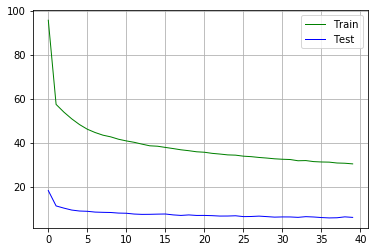

In [48]:
print ("Min values and epoch\ntrain: %s\ntest: %s" \
       %(np.array(train_epoch_loss_list).min(), np.array(test_epoch_loss_list).min()) )
train_loss, = plt.plot(train_epoch_loss_list, 'g-',linewidth = 1, label='Train')
test_loss, = plt.plot(test_epoch_loss_list, 'b-',linewidth = 1, label = "Test")
plt.legend(handles=[train_loss, test_loss])
plt.grid()
plt.show()

Save parameters to pickle file
====

In [ ]:
net_parametrs = net.state_dict()
with open('./result_nets.pkl','wb') as f:
    pickle.dump(net_parametrs,f)

Load parameters from pickle file
====

In [ ]:
with open('./result_nets.pkl','rb') as f:
    result_nets = pickle.load(f)
net.load_state_dict(result_nets)

Learn test data
====

In [ ]:
net.train(False)

batch_size = 1000
loss_acc = 0
Xperm = np.random.permutation(Xt.shape[0])
loss_fn = torch.nn.CrossEntropyLoss().cuda()
y_hat = []
for b in range(Xt.shape[0]//batch_size):
    batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
    x = Variable(torch.Tensor(Xt[batch_idxs].tolist()),volatile = True).cuda()
    y = Variable(torch.LongTensor(Yt[batch_idxs]),volatile = True).cuda()
    
    
    y_hat.append(net(x))
    loss = loss_fn(y_hat[b], y)
    loss_acc +=loss.data[0]

print (loss_acc / (Xt.shape[0]//batch_size))

Save result of test
====

In [ ]:
d = pandas.DataFrame()
d['id'] = range(len(Yt))
res = y_hat
if type(y_hat) == list:
    res = y_hat[0].data.cpu().numpy()
    for i in range(1, len(y_hat)):
        res = np.vstack((res, y_hat[i].cpu().data.numpy()))
        
for i in range(10):
    d['c%s' % i] = np.exp(res[:, i])

In [ ]:
d.to_csv('./ground.csv', index=False)

**Classes:**
======
1. airplane 
2. automobile
3. bird
4. cat
5. deer 
6. dog
7. frog
8. horse
9. ship
10. truck.

In [ ]:
class Hyperparams:
    def __init__(self):
        self.lr0 = 0.0001
        self.epoch = 0
        self.punch = 0.0003
        self.lr = 0.0001
        self.base = 0.5
    
    @property
    def rate(self):
        return self.epoch // 15
    
    def make_punch(self):
        self.lr = self.punch
        self.epoch = 0
        
    @property
    def updated_lr(self):
        return self.lr0 * ( self.base **  self.rate )